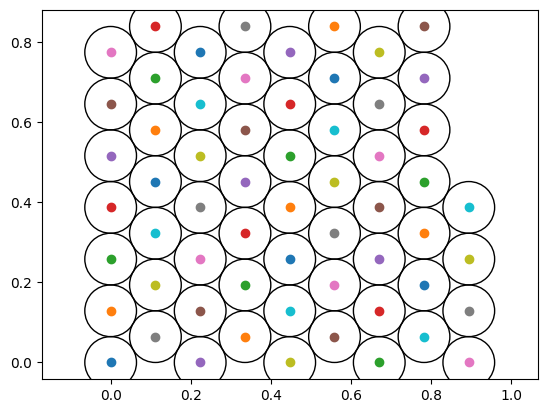

In [68]:
import time
from typing import List, Tuple

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy as sp
import scipy.optimize
import scipy.sparse
from networkx.drawing.layout import _process_params
from tqdm.auto import tqdm

from src.python.cost import calcCost
from src.python.vis.visGraph import visGraph

# def hexagon(n: int, k: float) -> np.ndarray:
#     # https://www.redblobgames.com/grids/hexagons/
#     ret = [(0, 0)]
#     if n == 1:
#         return np.array(ret)
#     diffs = [(0, k, -k), (-k, k, 0), (-k, 0, k), (0, -k, k), (k, -k, 0), (k, 0, -k)]
#     level = 0
#     while True:
#         q, r, s = k * level, -k * level, 0
#         for i in range(6):
#             for _ in range(level):
#                 ret.append(np.array([(q + r / 2), r * (3**0.5) / 2]))
#                 if len(ret) == n:
#                     return np.array(ret)
#                 q, r, s = q + diffs[i][0], r + diffs[i][1], s + diffs[i][2]
#         level += 1


def hexagon(n: int, k: float) -> np.ndarray:
    # https://www.redblobgames.com/grids/hexagons/
    sqrtN = int(np.sqrt(n))
    ret = []
    invSqrt3 = 1 / pow(3, 0.5)
    for q in range(sqrtN + 2):
        x = 1.5 * invSqrt3 * q * k
        for r in range(sqrtN):
            y = (r + 0.5 * (q % 2)) * k
            ret.append((x, y))
            if len(ret) == n:
                return np.array(ret)


def toHexagon(pos: np.ndarray, k: float) -> np.ndarray:
    n = len(pos)
    sqrtN = int(np.sqrt(n))
    args = np.argsort(pos[:, 0])
    pos[args, 0] = np.repeat(np.arange(n // sqrtN + 1), sqrtN)[:n]
    args = np.lexsort((pos[:, 1], pos[:, 0]))
    pos[args, 1] = np.tile(np.arange(sqrtN) * k, n // sqrtN + 1)[:n]
    pos[args, 1] += (pos[args, 0] % 2) * 0.5 * k
    pos[args, 0] *= 1.5 / pow(3, 0.5) * k
    return pos
    # ret = np.zeros((n, 2))
    # for i in range(sqrtN + 2):
    #     targetArgs = args[sqrtN * i : sqrtN * (i + 1)]
    #     argOfTargetArgs = np.zeros(targetArgs.shape[0], dtype=int)
    #     argOfTargetArgs[np.argsort(pos[targetArgs, 1])] = np.arange(targetArgs.shape[0])
    #     ret[targetArgs] = origPos[sqrtN * i + argOfTargetArgs]
    # return ret


def drawHexagon(pos: np.ndarray, k: float):
    for v in pos:
        plt.plot(v[0], v[1], "o")
        circle = plt.Circle(v, k / 2, color="k", fill=False)
        plt.gca().add_artist(circle)
    plt.axis("equal")
    plt.show()


n = 60
k = 1 / (n**0.5)
drawHexagon(hexagon(n, k), k)

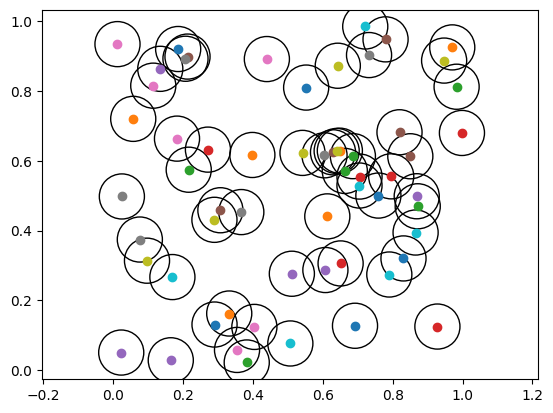

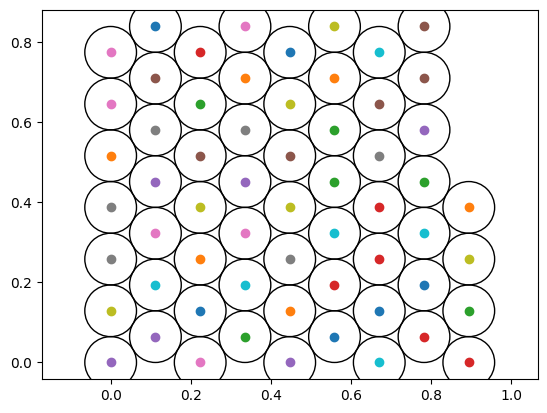

In [69]:
pos = np.random.rand(n, 2)
drawHexagon(pos, k)
pos = toHexagon(pos, k)
drawHexagon(pos, k)

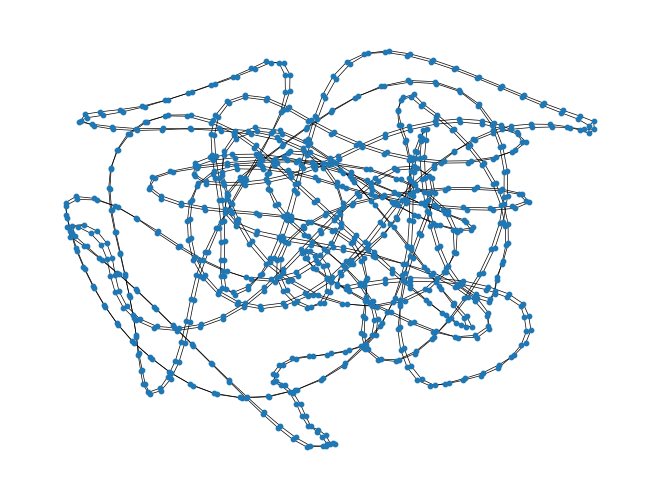

In [70]:
# G = nx.random_geometric_graph(600, 0.1, seed=0)
G = nx.circular_ladder_graph(500)
dim = 2
G, center = _process_params(G, None, dim)

A = nx.to_scipy_sparse_array(G, dtype="f")
n = G.number_of_nodes()
k = 1 / np.sqrt(n)
A = scipy.sparse.coo_matrix(A)

# pos = np.array([G.nodes[i]["pos"] for i in G.nodes])
# print(calcCost(pos, A, k))
pos = nx.spring_layout(G, seed=0)

nx.draw(G, pos, node_size=10, width=0.5)
plt.show()

# res = sp.optimize.minimize(cost_fun, pos.ravel(), method="L-BFGS-B", jac=True)
# pos = res.x.reshape((n, dim))
# print(calcCost(pos, A, k))

# nx.draw(G, pos, node_size=10, width=0.5)
# plt.show()

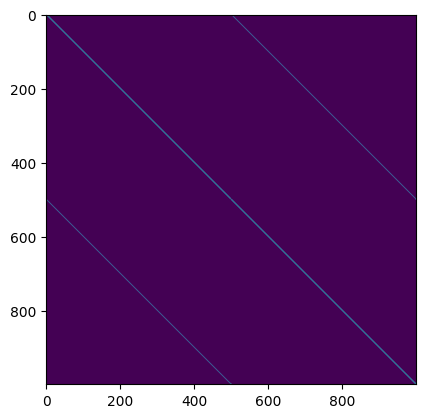

In [40]:
plt.imshow(A.todense())
plt.show()

In [41]:
assert np.all(A.data >= 0)

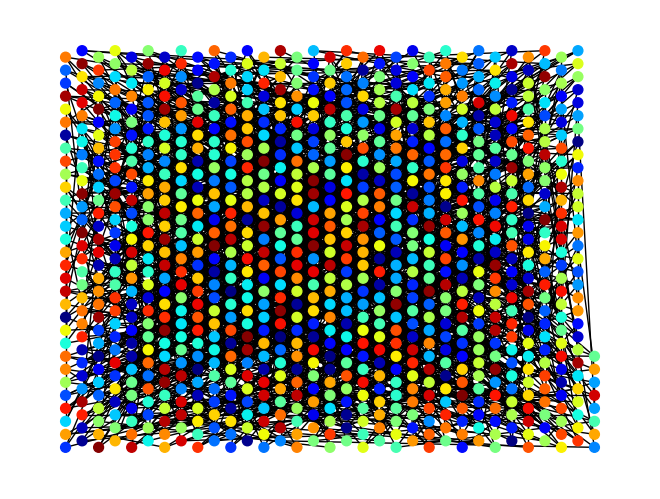

  0%|          | 0/1000 [00:00<?, ?it/s]

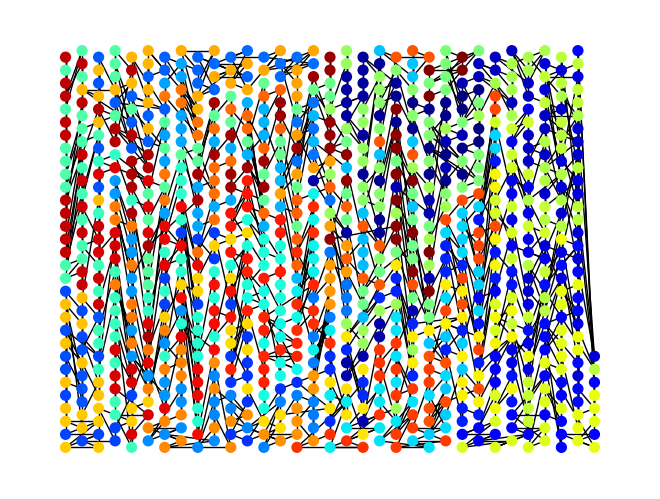

t1-t0=0.9277236999987508


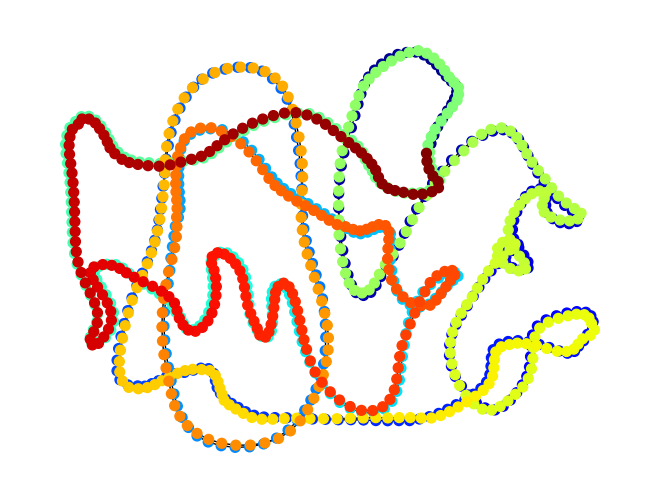

In [74]:
hexagonPos = hexagon(n, k)
assignment = np.arange(n)
np.random.shuffle(assignment)
pos = hexagonPos[assignment]
visGraph(G, pos)

iterations = 1000

delta = pos[:, np.newaxis, :] - pos[np.newaxis, :, :]
distance = np.linalg.norm(delta, axis=-1)
np.clip(distance, 0.01, None, out=distance)
# repulse = np.einsum("ijk,ij->ik", delta, k * k / distance**2)
repulse = np.zeros((n, 2))

t0 = time.perf_counter()
for _ in tqdm(range(iterations)):
    delta = pos[A.row] - pos[A.col]
    distance = np.linalg.norm(delta, axis=1)
    displacement = repulse
    np.add.at(displacement, A.row, (-A.data * distance / k)[:, np.newaxis] * delta)
    displacement /= np.linalg.norm(displacement, axis=1)[:, np.newaxis]
    displacement *= 2 * k
    pos += displacement
    # visGraph(G, pos)
    pos = toHexagon(pos, k)
visGraph(G, pos)
t1 = time.perf_counter()
print(f"{t1-t0=}")

pos = nx.spring_layout(G, seed=0, pos={i: pos[i] for i in range(n)})
visGraph(G, pos)

In [ ]:
A = A.tolil()


def cost_fun(x):
    EPS = 1e-10
    pos = x.reshape((n, dim))
    grad = np.zeros((n, dim))
    cost = 0.0
    for i in range(n):
        Ai = A.getrow(i).toarray().flatten()
        delta = pos[i] - pos
        assert np.all(delta[i] == 0.0)
        distance = np.linalg.norm(delta, axis=1)
        cost += np.sum(Ai * distance**3 / (3 * k) - (k**2) * np.log(distance + EPS))
        distance = np.where(distance < 0.01, 0.01, distance)
        distance_inv = 1 / distance
        coefficient1 = Ai * distance / k - (k * distance_inv) ** 2
        grad[i] = coefficient1 @ delta
    # print(f"{cost=}")
    return cost, grad.ravel()


pos_hist = []
res = sp.optimize.minimize(
    cost_fun,
    pos.ravel(),
    method="L-BFGS-B",
    jac=True,
    options={"maxiter": 30, "disp": True},
    callback=lambda x: pos_hist.append((x.reshape((n, dim)))),
)

print("!")
for pos in pos_hist:
    visGraph(G, pos)

pos = np.random.rand(n, 2)
pos_hist = []
res = sp.optimize.minimize(
    cost_fun,
    pos.ravel(),
    method="L-BFGS-B",
    jac=True,
    options={"maxiter": 30, "disp": True},
    callback=lambda x: pos_hist.append((x.reshape((n, dim)))),
)

print("!")
for pos in pos_hist:
    visGraph(G, pos)